# **MolecularDynamicsPBC class**

The aim of this notebook is to ilustrate all the functionalities of the `MolecularDynamicsPBC` class and explain some of the details of the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from molecular_dynamics import MolecularDynamicsPBC

from IPython.display import Video

In [2]:
model_params = { 
    'box_width' : 20,
    'gas_density' : 0.25,
    'time_step' : 5e-3,
    'initial_temperature' : 1.
}


model = MolecularDynamicsPBC(**model_params)

## 1 - The model

### 1.1 - Interaction potential

Here we will consider a set of $N$ *classical* particles of mass $m$ that interact pair-wise via the Lennard-Jones potential and moving according Newton's laws in two dimensions. The Lennard-Jones potential is given by 

$$
V(r_{ij}) = 4\epsilon\left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right],
$$

where $r_{ij} = r_{ji}$ is the Euclidean distance between the particles $i$ and $j$, $\epsilon$ is the strength of the potential and $\sigma$ is a length scale. 

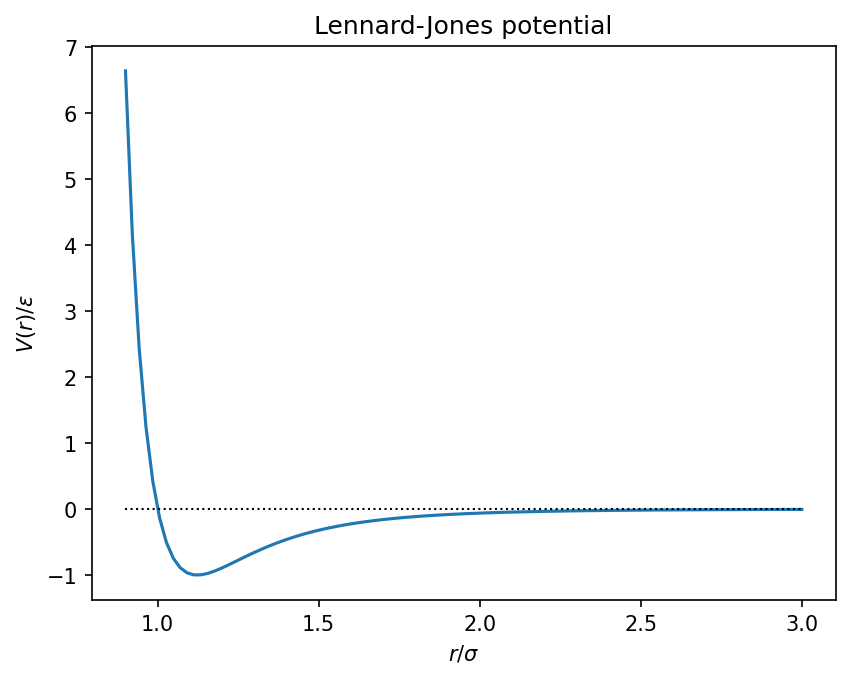

In [3]:
def v(x): 
    """Function that returns the Lennard-Jones potential"""
    return 4./(x**12) - 4./(x**6)

x = np.linspace(0.9, 3, 100)

fig = plt.figure(dpi = 150)
plt.plot(x, v(x))
plt.plot(x, 0*x, color = 'black', linestyle = 'dotted', linewidth = 1)
plt.title("Lennard-Jones potential")
plt.xlabel('$r/\\sigma$')
plt.ylabel('$V(r)/\\epsilon$')

plt.savefig('lennard_jones.png')

plt.show()

We see from the shape of the Lennard-Jones potential above that for long distances, i.e. for $r \gtrsim \sigma$, the potential is attractive, while for $r \lesssim \sigma$ the potential is strongly repulsive. The potential also has a minimum at $r_0 = 2^\frac{1}{6}\sigma$, where $V(r_0) = -\epsilon$.

This potential is a good model for innert gases, like ideal gases, that cannot for chemical bonds, i.e. cannot exchange electrons. The $\left(\frac{\sigma}{r}\right)^6$ tail models dipole interactions that are produce by the interaction of the molecules electronic clouds via the electorstatic force, that distorts the clouds, attractive producing electric dipole forces. The $\left(\frac{\sigma}{r}\right)^{12}$-term models the strong repulsion that appears out of the superpposition of the molecules electronic clouds, and it is produced by Pauli's exclusion principle. This principle express the empirical fact that two electrons cannot occupy the same state.  

### 1.2 Boundary conditions

For simplicit, we will consider periodic boundary conditions. This means that in a lattice of size $L$, if the particle moves to a position $x = L + a$, the particle is the moved to the position $x' = x - L = a$, assuming here $a < L$. Hence, if the particles leaves the lattice on the right, it reappers on the left. And vice-versa. If the particle moves to the position $x = a < 0$, then it is moved to the position $x' = a + L < L$.

This choice of boundary conditions have some advantages. In a real gas we typically have $N \sim 10^{23}$ particles, which would be very costly to simmulate in a computer. For small set of particles, say $N \sim 100$, assuming the the boundary of the lattice are hard walls as in a vessel might produce undesirable boundary effects that one would not find in real-life situations. The periodic boundary condition then allows us to simulate the situation in which we are observing a sample of the bulk of the gas, away from the vessel walls at a constant density 

## 2 - Method

### 2.1 - Numerical method

To numerically compute the position of the gas molecules, we will use the so-called **Verlet method**, see e.g. *Computational Physics* by N. Giordano. This method is suitable when the interaction potential does not depend on the velocity. Moreover it is a method easy to implement and has good numerical precision.

Let us consider a function $y(t)$ satisfy the equation of motion $\frac{d^2y(t)}{dt^2} = f[y(t)]$ and its Taylor expansion going forward and backward in time around the instant $t_i$ with a time step $\Delta t$,

$$
y(t_i + \Delta t) = y(t_i) + \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} + \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4)
$$
and
$$
y(t_i - \Delta t) = y(t_i) - \Delta t\frac{dy(t_i)}{dt} + \frac{1}{2}\Delta t^2\frac{d^2y(t_i)}{dt^2} - \frac{1}{6}\Delta t^3\frac{d^3y(t_i)}{dt^3} + O(\Delta t^4).
$$

Denoting $y_i \equiv y(t_i)$, $y_{i-1} \equiv y(t_i - \Delta t)$, $y_{i+1} \equiv y(t_i + \Delta t)$ and $f(y) = $, we have that

$$
y_{i + 1} = 2 y_i - y_{i - 1} + \Delta t^2f(y_i) + O(\Delta t^4),
$$

hence the error is of order $O(\Delta t^4)$. The Verlet method is thus approximates $\frac{d^2y}{dt^2}$ symmetrically using differences centered at the instant $t_i$ with high accurace. We can also obtain the velocity $v_i = \frac{dy_i}{dt}$ from the Verlet method by taking

$$
y_{i+1} - y_{i-1} = 2\Delta t v_i + O(\Delta t^3)\;\;\;\; \rightarrow \;\;\;\; v_i = \frac{y_{i+1} - y_{i-1}}{2\Delta t} + O(\Delta t^3).
$$

### 2.2 Computation of the force

The expression for the interaction force between two particles is

$$
\vec{F}(\vec{x} - \vec{x}') = \frac{24 \epsilon}{\sigma}\left[2\left(\frac{\sigma}{r}\right)^{13} - \left(\frac{\sigma}{r}\right)^7\right]
\frac{\vec{x} - \vec{x}'}{r} 
$$

with $r = \| \vec{x} - \vec{x}'\|$. 

To simplify the numerical computation we will only consider the interaction between particles that are apart by up to a distance of $3\sigma$. This introduces an error in the computation of force of the order $1/3^7 \sim 10^{-4}$. Hence, if we choose $\Delta t \sim 10^{-3}$, the error in the equation for the position is still consistent with the error in the equation for the velocity.

We also need to take into account the periodic boundary condition when computing the force so the reappearnce of a particle on the other side of the lattice is consistent with the dynamics. This is accomplished by computing the shortest distance between two particles and using it to compute the force between them. Hence, suppose two particles $i$ and $j$ at positions $x_i$ and $x_j$. If their coordinate distance is less than $L/2$, then we simply use $x_i - x_j$, otherwise we have to use the complement of the coordinate distance given by $x_i - x_j - \textrm{sgn}(x_i - x_j)L$. 

## 3 - Initial conditions

In [4]:
model.generate_initial_conditions(random_initial_position = True)

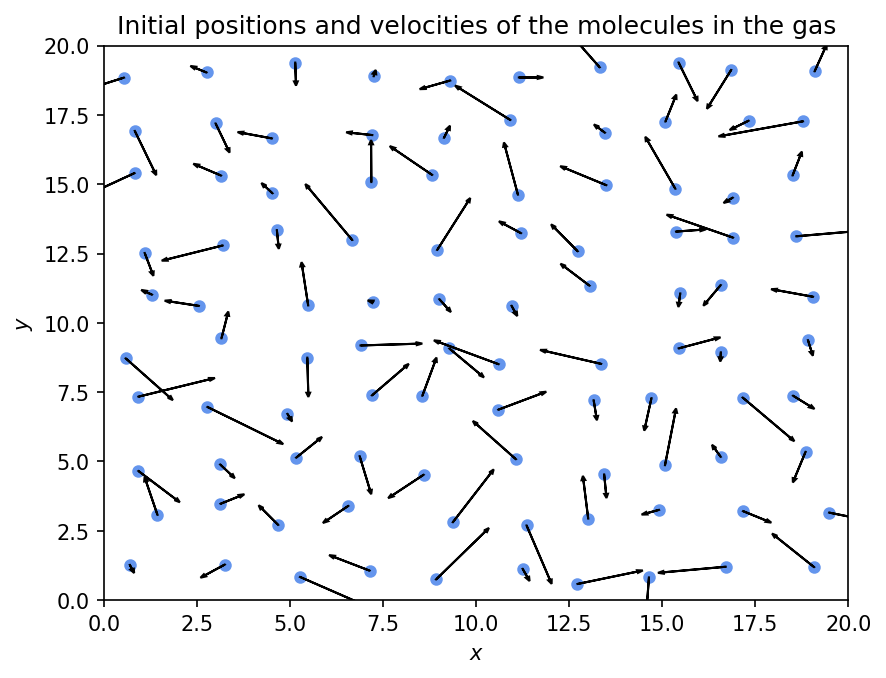

In [5]:
model.plot_initial_conditions()

## 4 - Forces

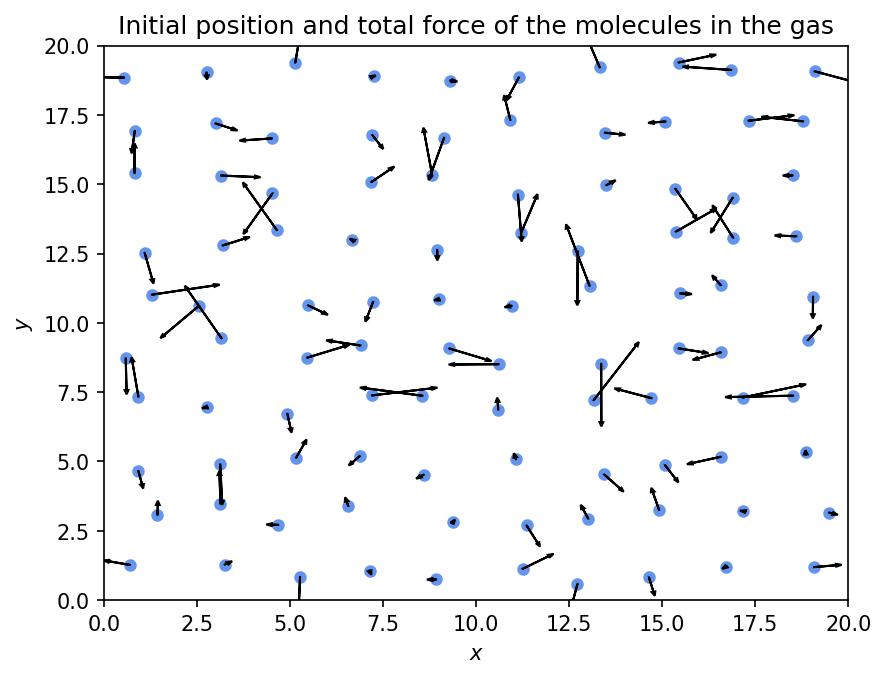

In [6]:
model.plot_initial_forces()

## 5 - Dynamics

In [7]:
model.generate_dynamics(total_time_steps = 6000)

In [8]:
model.generate_gas_animation()
Video("molecular_dynamics.mp4")

## 6 - Statistical measurements

### 6.1 - Maxwell-Boltzmann distribution

Here we will consider an ideal gas, i.e. a gas whose the energy of the interaction bewteen the atmons is negligible when compared to the kinetic energy. This is done by choosing the particles's initial state such that their separation is $\sim \sigma$ and velocity sufficiently high. Note that the initial state will not correspond to a thermal equilibrium state, so the collisions between the particles are still important to take the system to equilibrium.

Hence, let us assume that our system is well approximated by an ideal gas. Since the probability of finding the gas in a state with energy between $E$ and $E + dE$ is given $p(E)dE \propto \textrm{e}^{-\frac{E}{kT}}dE$, where $k$ is Boltzmann's constant and $T$ the temperature. For an ideal gas the particles are independent from each other and the energy is the kinetic energy, $E = \frac{1}{2}mv^2$. Hence, the propability of finding an atom with velocity modulus between $v$ and $v + dv$ in 2 spatial dimentions is  

$$
\eqalign{
p(E)dE & \propto \exp{\left(-\frac{m}{2kT}v^2\right)}\vec{v}\cdot d\vec{v} \cr 
& \propto v\exp{\left(-\frac{m}{2kT}v^2\right)}dv.
}
$$
The normalised propbability distribution for the velocity modulus then is
$$
f(v)dv = \frac{m}{kT} v \exp{\left(-\frac{m}{2kT}v^2\right)}dv,
$$
the Maxwell-Boltzmann distribution.

In [9]:
model.generate_velocity_distribution()

In [10]:
model.generate_velocity_distribution_animation()
Video("velocity_distribution.mp4")

### 6.2 - Measuring $kT$

To measure the temperature of our gas once it reaches thermal equilibrium, we can measure the velocity modulus distribution and then fit the resulting curve. For the fitting, we notice that for the discrete probability distribution $g(v)$ we have

$$
\ln g(v) = \ln\left(\frac{m\Delta v}{kT}\right) + \ln v - \frac{m}{2kT}v^2,
$$
and thus
$$
\ln\left(\frac{g(v)}{v}\right) = \ln\left(\frac{m\Delta v}{kT}\right) - \frac{m}{2kT}v^2,
$$
where $\Delta v$ is the finite size of the velocity bins. Thus, we can simply use a linear regression, after a log-log transformation of the velocity distribution.

Another possibility is to use the equipartion theorem, where each degree of freedom corresponds to $\frac{1}{2}kT$ in the mean energy. For a free particle in 2 dimension, we have that
$$
\left\langle E \right\rangle = kT
$$
and
$$
\left\langle v^2 \right\rangle = \frac{2kT}{m}. 
$$
Thus an alternative way to measure the temperature is to measure the mean of the squared velocity.

Measured kT after 6000 steps from fitting: 1.5965165760523425
 


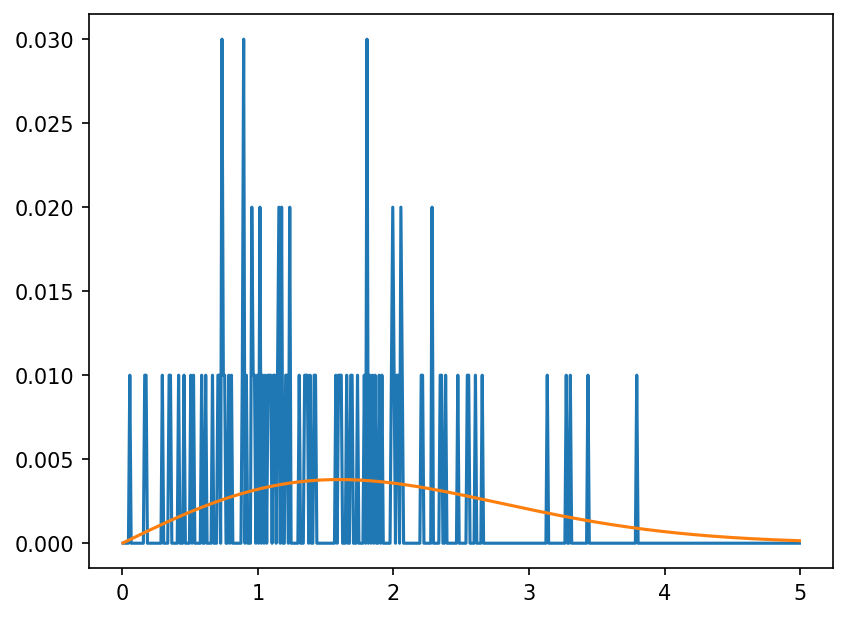

In [11]:
model.measure_kT(method = "instantaneous fitting")

Measured kT after 6000 steps from fitting: 1.2509519854730855
 


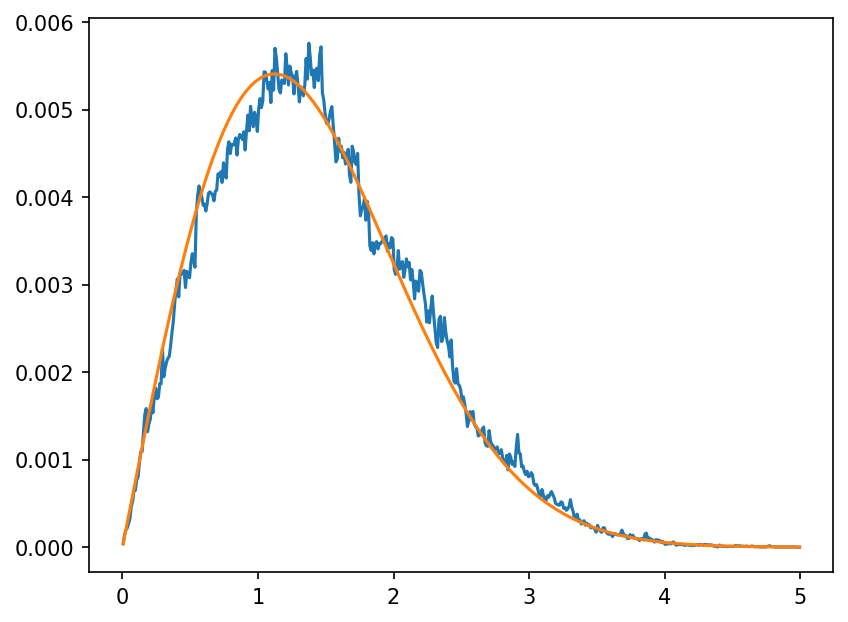

In [12]:
model.measure_kT(method = "cumulative fitting")

In [13]:
model.measure_kT(method = "equipartition")

Measured kT after 6000 steps from the equipartition theorem: 1.3448434858050493


## 7 - Thermostat

In [14]:
change_temperature_params = {"new_temperature" : 10.,
                            "extra_time_steps": 6000}

model.change_temperature(**change_temperature_params)

In [15]:
model.generate_gas_animation()
Video("molecular_dynamics.mp4")

In [16]:
model.generate_velocity_distribution()

In [17]:
model.generate_velocity_distribution_animation()
Video("velocity_distribution.mp4")

Measured kT after 11999 steps from fitting: 4.681861242291477
 


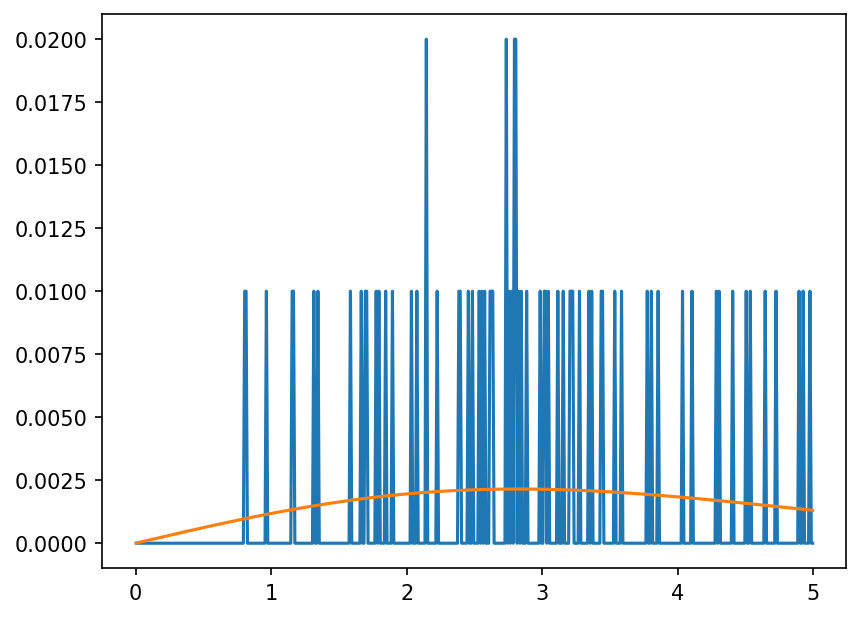

In [18]:
model.measure_kT(method = "instantaneous fitting")

Measured kT after 11999 steps from fitting: 3.587962425013318
 


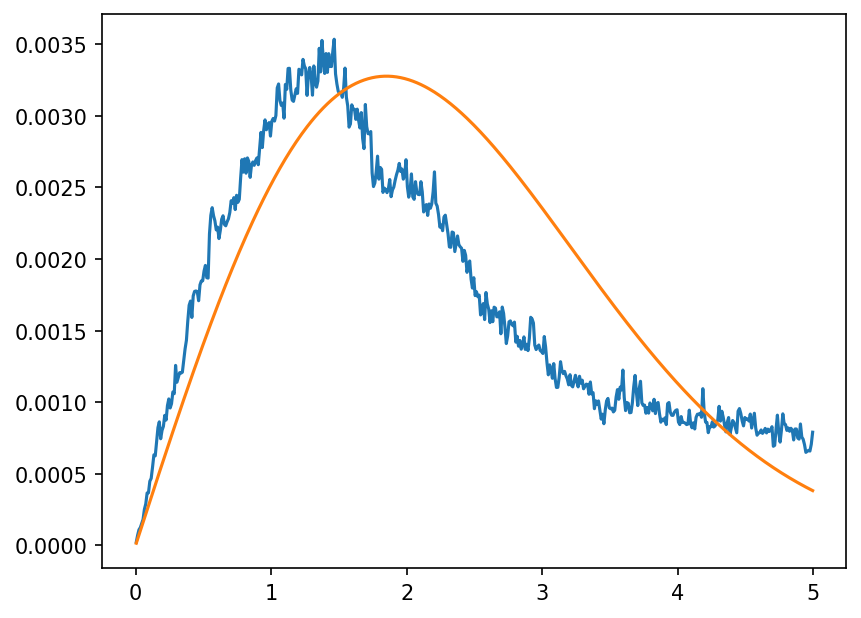

In [19]:
model.measure_kT(method = "cumulative fitting")

In [20]:
model.measure_kT(method = "equipartition")

Measured kT after 11999 steps from the equipartition theorem: 10.346426308473871


## 8 - Pressure

Average pressure after 11999: 10.996240189442604


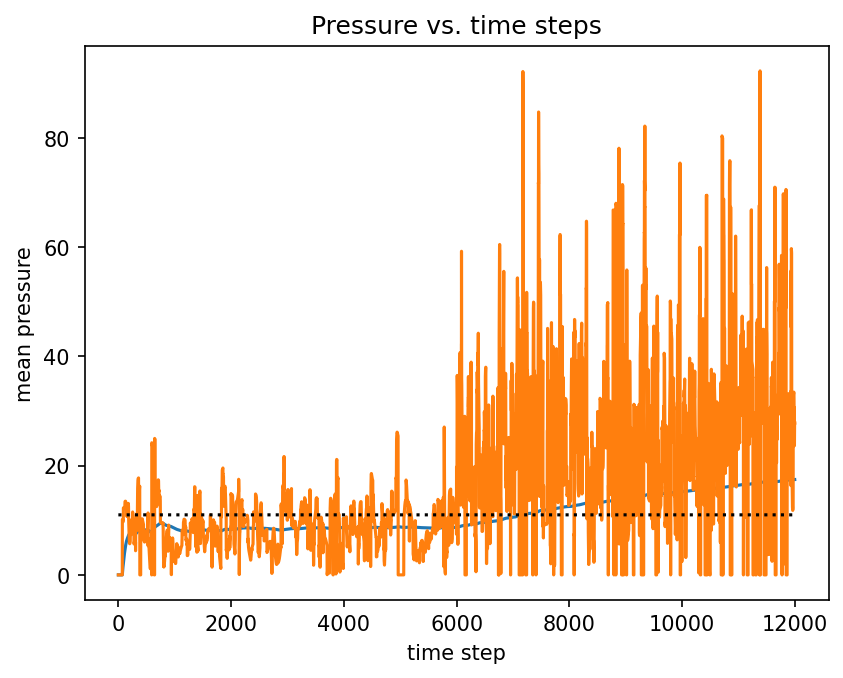

In [21]:
model.measure_pressure()